### OBJECTIVE
applying ULMFit to train an unsupervised language model to understand molecular structure. Since some steps (e.g. training and data augmentation) take a lot of time, to avoid timeout in jupyter notebook, some steps are delegated to ```train_molecule_lm.py```.

Note that this notebook mainly takes reference from **[XinhaoLi74/MolPMoFit](https://github.com/XinhaoLi74/MolPMoFiT)**. This notebook serves to:  
(i) replicate part of the result  
(ii) provided extended exploration to the original work

### EXTENSION
1. visualize molecular structure from its SMILES representation (COMPLETE)
2. query molecular with similar structure with the learned language model (TBD)
3. sequence are concatenated and randomly chopped in LM training? (TBD)
4. train out transformer as LM model
5. check the molecular LM model without augmentation

### REFERENCE
1. main reference: https://github.com/XinhaoLi74/MolPMoFiT
2. getting start with RDKit: https://www.rdkit.org/docs/GettingStartedInPython.html
3. visualize molecular structure by RDKit: http://davies-lee.com/index.php/2018/10/06/rdkit-in-jupyter-notebooks/

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from fastai import *
from fastai.text import *

from molecule_utils import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

#### 1. Read in Data for Training Language Model
We have 1M data points (SMILES representation of different moleculars). Note that second column ```canonical``` is not used in our case because the language model is trained in an unsupervised manner, meaning the model takes part of its input as label and don't need any external labels.

In [2]:
ls data/MSPM

ChemBL-LM_train.csv  ChemBL-LM_train.zip  ChemBL-LM_val.csv


In [2]:
train = pd.read_csv('data/MSPM/ChemBL-LM_train.csv')
valid = pd.read_csv('data/MSPM/ChemBL-LM_val.csv')
print(f'train data: {train.shape[0]}')
print(f'valid data: {valid.shape[0]}')

train data: 980000
valid data: 20000


In [4]:
train.head()

,SMILES,canonical
0,CC(=O)OC1=C(CC2CCCCC2)C(=O)c2ccccc2C1=O,yes
1,COc1ccc([N+](=O)[O-])cc1NC(=O)c1ccco1,yes
2,CC(C)C[C@@H]1NC(=O)[C@H](CC(C)C)NC(=O)[C@H](Cc...,yes
3,Cc1ccc(F)cc1S(=O)(=O)N[C@@H]1CCN(Cc2ccc3[nH]cc...,yes
4,CC(=O)N[C@@H](CSC(=O)Nc1ccc(C(F)(F)F)cc1[N+](=...,yes


#### 2. Visualize Molecule from Training Set
RDKit provides API to visualize molecular from its SMILES representation.

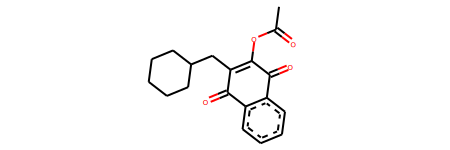

SMILES: CC(=O)OC1=C(CC2CCCCC2)C(=O)c2ccccc2C1=O


In [5]:
vis_molecular(train.SMILES.iloc[0])
print(f'SMILES: {train.SMILES.iloc[0]}')

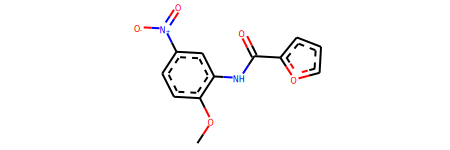

SMILES: COc1ccc([N+](=O)[O-])cc1NC(=O)c1ccco1


In [6]:
vis_molecular(train.SMILES.iloc[1])
print(f'SMILES: {train.SMILES.iloc[1]}')

In [7]:
# it takes a long time to run...
#%%time
#train_aug = smiles_augmentation(train, 4)
#valid_aug = smiles_augmentation(valid, 4)

#### 3. Molecular Tokenizer
Molecular sequence is completely different from human language. This session walks you through how we tokenize molecular structure representated in SMILES. 

Essentially, we want to break down a molecular structure into a collection of its constituent elements and bonds. Therefore, the tokenizer will give us elements that constitute the molecular, together with the bonds that connect them. 

However, some arrangements are done on sequence that starts with "[" and ends with "]"(e.g. "[N+]", "[NH2+]"). 

On top of that, "[BOS]" is appended at the beginning of each sequence to signify to the model the beginning of a sequence. 

In [3]:
mol_tokenizer = MolTokenizer()

In [9]:
print(f"before: {train.SMILES[11]}")
print(f"after: {' '.join(mol_tokenizer.tokenizer(train.SMILES[11]))}")

before: CCCCCC(C)NC(=O)c1ccoc1C
after: [BOS] C C C C C C ( C ) N C ( = O ) c 1 c c o c 1 C


In [10]:
print(f"before: {train.SMILES[3]}")
print(f"after: {' '.join(mol_tokenizer.tokenizer(train.SMILES[3]))}")

before: Cc1ccc(F)cc1S(=O)(=O)N[C@@H]1CCN(Cc2ccc3[nH]ccc3c2)C1
after: [BOS] C c 1 c c c ( F ) c c 1 S ( = O ) ( = O ) N [C@@H] 1 C C N ( C c 2 c c c 3 [nH] c c c 3 c 2 ) C 1


#### 4. Setup DataBunch

In [4]:
path = Path('results/MSPM')
path.mkdir(exist_ok = True, parents = True)

In [5]:
# set up mini-data set for fast testing
train_mini = train[:5000]
valid_mini = valid[:500]

In [6]:
tok = Tokenizer(partial(MolTokenizer, special_tokens = special_tokens), n_cpus=6, pre_rules=[], post_rules=[])

In [7]:
%%time
bs = 128 # batch size

data = TextLMDataBunch.from_df(path, train_mini, valid_mini, 
                               bs = bs, tokenizer = tok, 
                               chunksize = 50000, 
                               text_cols = 0, max_vocab = 60000, 
                               include_bos = False) # coz Tokenizer already handle that

CPU times: user 227 ms, sys: 205 ms, total: 432 ms
Wall time: 553 ms


Note that some data have [BOS] . It is related to the way ULMFit trains a language model -- It concatenate data points and randomly chopped in between and take it as training data.

In [15]:
data.show_batch()

idx,text
0,o 1 [BOS] C C ( C ) C [C@@H] 1 N C ( = O ) [C@H] ( C C ( C ) C ) N C ( = O ) [C@H] ( C c 2 c c c c c 2 ) N C ( = O ) [C@@H] ( C O ) N C ( = O ) [C@H] ( C C ( C ) C )
1,( S ( = O ) ( = O ) N ( C C C c 2 c c c c c 2 ) c 2 c c c ( O c 3 c c c c c 3 ) c c 2 ) c c 1 [BOS] C N 1 C C N ( C c 2 c ( C # N ) c 3
2,[nH] 1 [BOS] C O c 1 c c ( F ) c ( N 2 C [C@H] ( C ) N [C@H] ( C ) C 2 ) c c 1 N S ( = O ) ( = O ) c 1 c c c ( - c 2 c c c c n 2 ) s 1 [BOS] C S c 1 c c c 2
3,3 c c c ( / C = C / C ( = O ) N 4 C C O C C 4 ) c ( C ( F ) ( F ) F ) c 3 C ( F ) ( F ) F ) c 2 ) C C 1 [BOS] O = C ( O ) c 1 c c c c ( C ( = O
4,( = O ) n ( C ( C ) C ) c ( = O ) n 2 C c 2 c c c ( Cl ) c c 2 ) c c 1 [BOS] C C O C ( = O ) [C@@H] 1 C [C@H] ( N C ( = O ) c 2 c c c 3 c c c c c 3 c 2


In [16]:
print(f'vocab size: {len(data.vocab.itos)}')

vocab size: 48


In [17]:
data.vocab.itos[:10]

['xxpad', 'c', 'C', '(', ')', '1', 'O', '2', '=', 'N']

#### 5. [AWD_LSTM] Load in Model and Find Learning Rate

In [8]:
data_lm = data

In [19]:
learner = language_model_learner(data_lm, AWD_LSTM, drop_mult = 1, pretrained = False)

In [20]:
learner.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(48, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(48, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=48, bias=True)
    (output_dp): RNNDropout()
  )
)

In [21]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


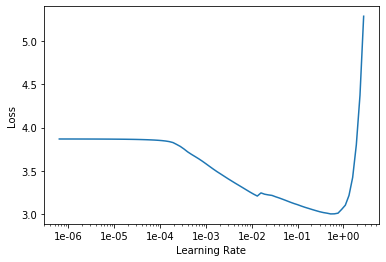

In [22]:
learner.recorder.plot()

#### 6. [TRANSFORMER] Load in Model and Find Learning Rate

In [7]:
bs = 64 # batch size

data_lm = TextLMDataBunch.from_df(path, train_mini, valid_mini, 
                                  bs = bs, tokenizer = tok, 
                                  chunksize = 50000, 
                                  text_cols = 0, max_vocab = 60000, 
                                  include_bos = False) # coz Tokenizer already handle that

In [8]:
learner = language_model_learner(data_lm, Transformer, drop_mult = 1, pretrained = False)

In [9]:
learner.model

SequentialRNN(
  (0): Transformer(
    (encoder): Embedding(48, 768)
    (pos_enc): Embedding(512, 768)
    (drop_emb): Dropout(p=0.1, inplace=False)
    (layers): ModuleList(
      (0): DecoderLayer(
        (mhra): MultiHeadAttention(
          (attention): Linear(in_features=768, out_features=2304, bias=True)
          (out): Linear(in_features=768, out_features=768, bias=True)
          (drop_att): Dropout(p=0.1, inplace=False)
          (drop_res): Dropout(p=0.1, inplace=False)
          (ln): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (ff): SequentialEx(
          (layers): ModuleList(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GeLU()
            (2): Linear(in_features=3072, out_features=768, bias=True)
            (3): Dropout(p=0.1, inplace=False)
            (4): MergeLayer()
            (5): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          )
        )
      )
      (1): DecoderLayer(
   

In [10]:
learner.lr_find()

/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/c

/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/c

/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/c

/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/c

/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/c

/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/c

/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/c

/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/c

/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/c

/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/c

/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/c

/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/c

/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/c

/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/c

/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/c

/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/c

/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/c

/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/c

/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/c

/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/c

/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/c

/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/c

/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/c

/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/c

/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/c

/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/c

/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/c

/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/c

/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/opt/conda/c

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


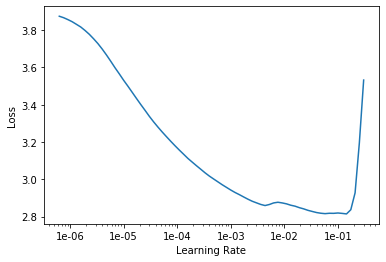

In [11]:
learner.recorder.plot()